In [1]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.2 MB/s 


In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score ,recall_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
import keras
from keras.layers import Dense
from keras.models import Sequential

from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers

from numpy import average
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_set=pd.read_csv('/content/drive/MyDrive/Lung Cancer Project/Lung Cancer CSV/train_datasetset1.csv')
test_set=pd.read_csv('/content/drive/MyDrive/Lung Cancer Project/Lung Cancer CSV/unseen_dataset1.csv')
train_set.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
1,F,75,1,2,1,2,2,2,2,1,2,2,1,1,1,YES
2,F,56,1,1,2,2,2,2,2,2,2,1,2,2,2,YES
3,M,66,1,2,2,1,2,1,2,1,2,2,2,1,2,YES
4,F,78,2,2,2,2,1,2,1,2,1,2,2,2,1,YES


In [5]:

X_train1=train_set.drop(columns =['LUNG_CANCER'], axis = 1)
y_train1=train_set['LUNG_CANCER']
X_train1.shape, y_train1.shape

((247, 15), (247,))

In [6]:
y_test1=test_set['LUNG_CANCER']
X_test1=test_set.drop(columns =['LUNG_CANCER'], axis = 1)
X_test1.shape, y_test1.shape

((62, 15), (62,))

In [7]:
num_features=len(X_train1.columns)

In [8]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
encoder_X = LabelEncoder()
X_train1['GENDER']= encoder_X.fit_transform(X_train1['GENDER'])
X_test1['GENDER'] = encoder_X.transform(X_test1['GENDER'])

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train1)
scaler1 = MinMaxScaler(feature_range=(0, 1))
X_test = scaler1.fit_transform(X_test1)

In [10]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
encoder_train_y = LabelEncoder()
encoded_Y= encoder_train_y.fit_transform(y_train1)
y_train = np_utils.to_categorical(encoded_Y)
encoder_test_y = LabelEncoder()
y_test = encoder_test_y.fit_transform(y_test1)
y_test_best=np_utils.to_categorical(y_test)

In [11]:
Epochs=70
Batch_size=10

In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
def build_model(hp):
    num_units_min  =  50
    num_units_max  =  700
    num_units_step =  20

    dropout_min  =  .2
    dropout_max  =  0.9
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 input_dim=num_features, activation='relu'))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('unitfor_'+ str(i),
                                            min_value=50,
                                            max_value=500,
                                            step=20),
                                          activation='relu'          
                                         ))
        
        model.add(layers.Dropout(hp.Float('dropout_2'+ str(i),min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
    
    model.add(layers.Dense(2, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[ 1e-4])),
       loss='binary_crossentropy', 
       metrics=['acc',f1_m,precision_m, recall_m])
    return model


In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=30,
    project_name='/content/drive/MyDrive/Lung Cancer Project/Lung Cancer CSV/RNN1')


In [17]:

early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

h=tuner.search(X_train, y_train,
             epochs=Epochs,
             batch_size=Batch_size, 
             callbacks=callback_list, validation_data=(X_test,y_test_best) )
            
model = tuner.get_best_models(num_models=1)[0]


Trial 30 Complete [00h 00m 17s]
val_acc: 0.9193548560142517

Best val_acc So Far: 0.9354838728904724
Total elapsed time: 00h 07m 20s
INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.get_best_hyperparameters()[0].values

{'dropout_20': 0.6000000000000001,
 'dropout_21': 0.7000000000000002,
 'learning_rate': 0.0001,
 'num_layers': 2,
 'unit1': 590,
 'unitfor_0': 450,
 'unitfor_1': 250}

In [21]:
AccuracyTrain=[]
PrecisionTrain=[]
RecallTrain=[]
F1Train=[]
Roc_auc_Train=[]
AccuracyTest=[]
PrecisionTest=[]
RecallTest=[]
F1Test=[]
Roc_auc_Test=[]
from sklearn.model_selection import KFold 

for i in range(0,1):    
    if i==0:
        r=70
    elif i== 1:
        r=80
  
    
    kf = KFold(n_splits=10,random_state=r,shuffle=True) 
    for train_index, test_index in kf.split(X_train):
        X_t, X_val = X_train[train_index], X_train[test_index] 
        y_t, y_val = y_train[train_index], y_train[test_index]
        h=model.fit(X_t, y_t, epochs=Epochs, batch_size=Batch_size,  verbose=1, shuffle=True, validation_data=(X_val,y_val))

        AccuracyTrain.append(round(100*np.mean(h.history['val_acc']),2))
        
        PrecisionTrain.append(round(100*np.mean(h.history['val_precision_m']),2))
       
        RecallTrain.append(round(100*np.mean(h.history['val_recall_m']),2))
        
        F1Train.append(round(100*np.mean(h.history['val_f1_m']),2))
        

Epoch 1/70
23/23 [==============================] - 0s 7ms/step - loss: 0.0567 - acc: 0.9775 - f1_m: 0.9807 - precision_m: 0.9794 - recall_m: 0.9826 - val_loss: 0.1556 - val_acc: 0.9200 - val_f1_m: 0.9333 - val_precision_m: 0.9333 - val_recall_m: 0.9333
Epoch 2/70
23/23 [==============================] - 0s 5ms/step - loss: 0.0524 - acc: 0.9820 - f1_m: 0.9826 - precision_m: 0.9830 - recall_m: 0.9826 - val_loss: 0.1619 - val_acc: 0.9200 - val_f1_m: 0.9333 - val_precision_m: 0.9333 - val_recall_m: 0.9333
Epoch 3/70
23/23 [==============================] - 0s 6ms/step - loss: 0.0558 - acc: 0.9730 - f1_m: 0.9739 - precision_m: 0.9739 - recall_m: 0.9739 - val_loss: 0.2050 - val_acc: 0.8800 - val_f1_m: 0.9000 - val_precision_m: 0.9000 - val_recall_m: 0.9000
Epoch 4/70
23/23 [==============================] - 0s 6ms/step - loss: 0.0488 - acc: 0.9820 - f1_m: 0.9824 - precision_m: 0.9870 - recall_m: 0.9783 - val_loss: 0.2178 - val_acc: 0.8800 - val_f1_m: 0.9000 - val_precision_m: 0.9000 - val_r

In [22]:
for i in range(0,1): 
    model.fit(X_train, y_train, epochs=Epochs, batch_size=Batch_size,  verbose=1, shuffle=True)
    y_p = model.predict(X_test)
    y_pred= np.argmax(y_p, axis=1)
    

    Accurcy_Test= accuracy_score(y_test,y_pred)
    Precision_Test=precision_score(y_test, y_pred,average='weighted')

    Recall_Test=recall_score(y_test, y_pred, average='weighted')
    F1_Test=f1_score(y_test, y_pred, average='weighted') 

    AccuracyTest.append(round(100*Accurcy_Test, 2))
    PrecisionTest.append(round(100*Precision_Test, 2))
    RecallTest.append(round(100*Recall_Test, 2))
    F1Test.append(round(100*F1_Test, 2))
    

Epoch 1/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0254 - acc: 0.9919 - f1_m: 0.9920 - precision_m: 0.9920 - recall_m: 0.9920
Epoch 2/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0284 - acc: 0.9919 - f1_m: 0.9901 - precision_m: 0.9884 - recall_m: 0.9920
Epoch 3/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0283 - acc: 0.9879 - f1_m: 0.9880 - precision_m: 0.9880 - recall_m: 0.9880
Epoch 4/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0251 - acc: 0.9879 - f1_m: 0.9880 - precision_m: 0.9880 - recall_m: 0.9880
Epoch 5/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0400 - acc: 0.9798 - f1_m: 0.9800 - precision_m: 0.9800 - recall_m: 0.9800
Epoch 6/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - acc: 0.9879 - f1_m: 0.9880 - precision_m: 0.9884 - recall_m: 0.9880
Epoch 7/70
25/25 [==============================] - 0s 4ms/step - loss: 0.0339 - acc: 0.9838 - f1_m: 0.982

In [23]:
finaltrain = pd.DataFrame([])

finaltrain = finaltrain.append({'AccuracyTrain' : round(np.mean(AccuracyTrain),2),
                                'PrecisionTrain':round(np.mean(PrecisionTrain),2),
                                'RecallTrain':round(np.mean(RecallTrain),2),  
                                'F1Train':round(np.mean(F1Train),2)

                               
                               } , ignore_index=True)



In [24]:
finaltrain.reindex(['AccuracyTrain','PrecisionTrain','RecallTrain','F1Train'], axis=1)

,AccuracyTrain,PrecisionTrain,RecallTrain,F1Train
0,95.9,96.36,96.24,96.29


In [25]:
ReultofTest=pd.DataFrame([])
ReultofTest=ReultofTest.append({'AccuracyTest' : round(np.mean(AccuracyTest),2),'PrecisionTest':round(np.mean(PrecisionTest),2),
             'RecallTest' : round(np.mean(RecallTest),2),'F1Test':round(np.mean(F1Test),2)}, ignore_index=True)

ReultofTest.reindex(['AccuracyTest','PrecisionTest','RecallTest','F1Test'], axis=1)

,AccuracyTest,PrecisionTest,RecallTest,F1Test
0,90.32,89.48,90.32,89.72


In [30]:
print(classification_report(y_test,y_pred , target_names=['NO','YES']))

              precision    recall  f1-score   support

          NO       0.67      0.50      0.57         8
         YES       0.93      0.96      0.95        54

    accuracy                           0.90        62
   macro avg       0.80      0.73      0.76        62
weighted avg       0.89      0.90      0.90        62



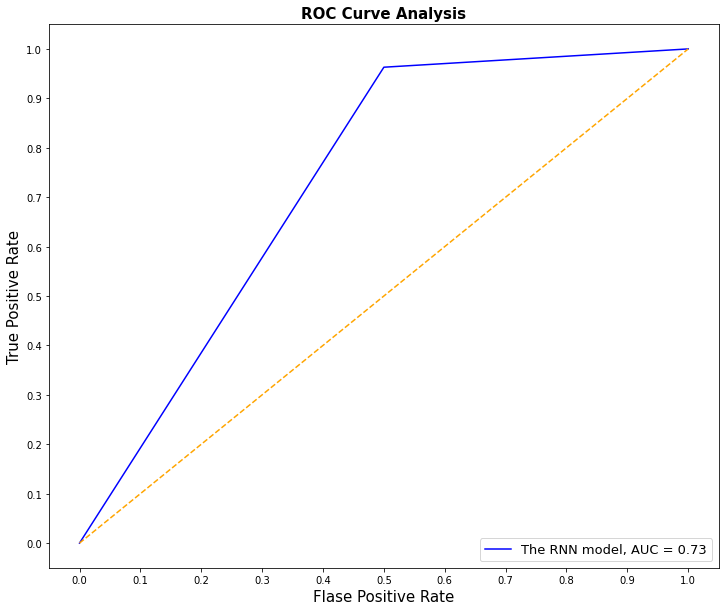

In [27]:
import sklearn.metrics as metrics


fig = plt.figure(figsize=(12,10))

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = round(np.mean(metrics.auc(fpr, tpr)),2)


plt.plot(fpr, tpr, 'b', label = 'The RNN model, AUC = %0.2f' % roc_auc)

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()